In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from typing import List, Dict, Tuple, Optional
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
tqdm.pandas()
sns.set_context("paper")

In [75]:
path_to_results_dir: str = '/share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/ppl/val'
variant: str = 'dataset=FEMRDataset-stride=32-n_patients=1000-is_config=False'

path_to_results: str = os.path.join(path_to_results_dir, variant)

N_SPECIAL_TOKENS: int = 7 # number of special tokens in tokenizer (useful for offseting to realign with original CLMBR vocab)

# Stability of Calculating PPL v. # Patients Sampled

How stable is our estimate of val/ppl v. number of patients?

**Experiment:**
* Calculate val/ppl for same model across 1k, 5k, 10k, 20k val patients and measure deviation.

NOTE: It takes ~2.5 hrs for 10k patients.

Run these commands to generate results used in this section:

```bash
# Stability of PPL
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 1000 # 0.1 hrs
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 5000 # 0.5 hrs
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 10000 # 2.5 hrs
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 50000 # 5.5 hrs
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 100000
```

In [4]:
path_to_base_results: str = '/share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr/ppl/val/'
path_to_1k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=1000-is_config=False')
path_to_5k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=5000-is_config=False')
path_to_10k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=10000-is_config=False')
path_to_50k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=50000-is_config=False')
path_to_100k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=100000-is_config=False')
file_name: str = 'train-tokens-total_nonPAD-true_val=2400000000-ckpt_val=2400000000-persist'

def parse_json(path: str) -> Dict:
    df = pd.read_parquet(path + '.parquet')
    mean_loss_per_token = df['label_log_prob'].mean()
    median_loss_per_token = df['label_log_prob'].median()
    mean_ppl_per_token = df['label_ppl'].mean()
    median_ppl_per_token = df['label_ppl'].median()
    ppl = np.exp(-mean_loss_per_token)
    return { 
        'mean_loss_per_token' : mean_loss_per_token, 
        'median_loss_per_token' : median_loss_per_token, 
        'overall_ppl': ppl,
        'mean_ppl_per_token': mean_ppl_per_token, 
        'median_ppl_per_token': median_ppl_per_token, 
    }

df = pd.DataFrame({
    '1k': parse_json(os.path.join(path_to_1k, file_name)),
    '5k': parse_json(os.path.join(path_to_5k, file_name)),
    '10k': parse_json(os.path.join(path_to_10k, file_name)),
    '50k': parse_json(os.path.join(path_to_50k, file_name)),
    # '100k': parse_json(os.path.join(path_to_100k, file_name)),
}).T
df

,mean_loss_per_token,median_loss_per_token,overall_ppl,mean_ppl_per_token,median_ppl_per_token
1k,-2.204538,-1.615794,9.066060,7317.615193,5.031883
5k,-2.164920,-1.586860,8.713906,15497.923462,4.888376
10k,-2.143968,-1.560286,8.533232,12264.440135,4.760184
50k,-2.133316,-1.555288,8.442814,18175.526610,4.736449


# What does the PPL distribution look like?

Let's do some EDA.

In [5]:
df = pd.read_parquet(os.path.join(path_to_10k, file_name) + '.parquet')

In [41]:
def print_percentiles(values: pd.Series):
    percentiles = [  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 95, 99, 100]
    percentile_values = np.percentile(values, percentiles)
    df_percentiles = pd.DataFrame({
        'percentile': percentiles,
        'value': percentile_values
    })
    with pd.option_context('display.float_format', lambda x: '%.3f' % x):
        print("==== Percentiles ====")
        print(df_percentiles)

with pd.option_context('display.float_format', lambda x: '%.3f' % x):
    print("==== Overview ====")
    print(df['label_ppl'].describe())
    print_percentiles(df['label_ppl'])

==== Overview ====
count       7407861.000
mean          12264.440
std         8205482.023
min               1.000
25%               1.680
50%               4.760
75%              20.161
max     21648180707.099
Name: label_ppl, dtype: float64
==== Percentiles ====
    percentile           value
0            0           1.000
1           10           1.058
2           20           1.384
3           30           2.037
4           40           3.102
5           50           4.760
6           60           7.510
7           70          13.610
8           80          33.210
9           90         164.178
10          95         765.303
11          99       16672.829
12         100 21648180707.099


In [15]:
# Who is the major outlier?
df.iloc[df['label_ppl'].argmax()]

pid                                          29944812
n_events                                         5017
n_tokens                                         4109
token_idx                                          85
label                                           11515
label_log_prob                             -23.798187
argmax_label                                     1653
argmax_log_prob                             -0.000396
label_ppl                          21648180707.099365
label_as_token                       SNOMED/282741006
label_as_token_desc            Post-herpetic neuritis
argmax_ppl                                   1.000396
argmax_as_token                      SNOMED/408277005
argmax_as_token_desc    APTT inhibitor screening test
Name: 2924516, dtype: object

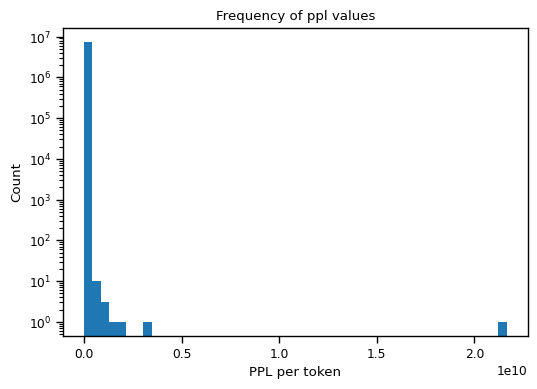

In [16]:
plt.figure(figsize=(6, 4))
plt.hist(df['label_ppl'], bins=50, log=True)  # Apply log scale to y-axis (or x-axis if needed)
plt.xlabel('PPL per token')
plt.ylabel('Count')
plt.title('Frequency of ppl values')
plt.show()

## PPL v. token position

Given a token's location in a sequence, what is the median ppl we can expect?

**Experiment:**
* Run `gpt-base-1024--clmbr` on validation patients, track the ppl for each token, then plot the median ppl observed at each sequence position 

NOTE: Use median instead of mean due to huge right skew outliers

In [17]:
print_percentiles(df[df['token_idx'] == 0]['label_ppl'])
print_percentiles(df[df['token_idx'] == 1]['label_ppl'])
print_percentiles(df[df['token_idx'] == 2]['label_ppl'])

==== Percentiles ====
    percentile          ppl
0            0        2.369
1           10        2.369
2           20        2.369
3           30        2.971
4           40        2.971
5           50        2.971
6           60        7.038
7           70        7.038
8           80        7.038
9           90       17.102
10          95       17.102
11          99      306.649
12         100 19116160.155
==== Percentiles ====
    percentile          ppl
0            0        1.000
1           10        1.002
2           20        1.004
3           30        1.004
4           40        1.004
5           50        4.040
6           60        5.552
7           70        6.506
8           80       10.815
9           90       64.906
10          95     1099.603
11          99    63749.762
12         100 46621117.571
==== Percentiles ====
    percentile          ppl
0            0        1.000
1           10        1.187
2           20        1.207
3           30        1.233
4         

In [172]:
def calculate_ppl_per_token_pos(df: pd.DataFrame, min_token_count: int = 30) -> pd.DataFrame:
    """Calculate token position v. median val/ppl"""

    # Count token position frequencies
    df_token_position_counts = df['token_idx'].value_counts().sort_index().reset_index()

    # Filter out any token positions with < min_token_count occurrences
    keep_token_idxs: List[int] = df_token_position_counts[df_token_position_counts['count'] >= min_token_count]['token_idx'].tolist()
    print(f"Keeping {len(keep_token_idxs)} token positions (i.e. all token positions with >= {min_token_count} data points)")

    df_pos_to_ppl = []
    for token_idx in tqdm(keep_token_idxs, desc='Processing token positions'):
        # 1. Calculate median PPL for this token positions
        df_token_idx = df[df['token_idx'] == token_idx]
        median = df_token_idx['label_ppl'].median()
        # 2. Calculate 95% CI
        # Sort the data
        sorted_data = df_token_idx['label_ppl'].sort_values().values
        n = len(sorted_data)
        # Calculate the ranks for the 95% confidence interval
        lower_rank = int(np.floor(0.5 * n - 1.96 * np.sqrt(n) / 2))
        upper_rank = int(np.ceil(0.5 * n + 1.96 * np.sqrt(n) / 2))
        lower_rank = max(0, lower_rank)
        upper_rank = min(n - 1, upper_rank)
        lower_bound = sorted_data[lower_rank]
        upper_bound = sorted_data[upper_rank]
        df_pos_to_ppl.append({
            'token_idx': token_idx,
            'median': median,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        })
    df_pos_to_ppl = pd.DataFrame(df_pos_to_ppl)
    df_pos_to_ppl['ema_median'] = df_pos_to_ppl['median'].ewm(span=20, adjust=False).mean()
    return df_pos_to_ppl

def plot_token_idx_v_ppl(df_pos_to_ppl: pd.DataFrame, ctx_length: int, is_use_ema: bool = False, is_show_ci: bool = False, is_zoom_to_ctx: bool = False):
    """Plot token position v. median PPL"""
    assert 'token_idx' in df_pos_to_ppl.columns, "token_idx column not found in df_pos_to_ppl"
    assert 'lower_bound' in df_pos_to_ppl.columns, "lower_bound column not found in df_pos_to_ppl"
    assert 'upper_bound' in df_pos_to_ppl.columns, "upper_bound column not found in df_pos_to_ppl"
    plt.figure(figsize=(6, 4))
    if is_use_ema:
        # Use exponential moving average of median PPL
        assert 'ema_median' in df_pos_to_ppl.columns, "ema_median column not found in df_pos_to_ppl"
        plt.plot(df_pos_to_ppl['token_idx'], df_pos_to_ppl['ema_median'], label='Median PPL (EMA)')
    else:
        # Use raw median PPL
        assert 'median' in df_pos_to_ppl.columns, "median column not found in df_pos_to_ppl"
        plt.plot(df_pos_to_ppl['token_idx'], df_pos_to_ppl['median'], label='Median PPL')
    if is_show_ci:
        plt.fill_between(df_pos_to_ppl['token_idx'], df_pos_to_ppl['lower_bound'], df_pos_to_ppl['upper_bound'], alpha=0.3, color='green', label='95% CI')
    plt.xlabel('Token position')
    plt.ylabel('Median PPL')
    plt.title('Token position v. Median PPL' + (' (EMA)' if is_use_ema else ''))
    plt.axvline(x=ctx_length-1, color='red', linestyle='--', label=f'ctx length = {ctx_length}')
    if is_zoom_to_ctx:
        plt.xlim(-10, ctx_length + 100)
        plt.ylim(2, 8)
    plt.legend()
    plt.show()

Keeping 10975 token positions (i.e. all token positions with >= 100 data points)


Processing token positions:   0%|          | 10/10975 [00:00<01:50, 98.89it/s]

Processing token positions: 100%|██████████| 10975/10975 [01:25<00:00, 128.80it/s]


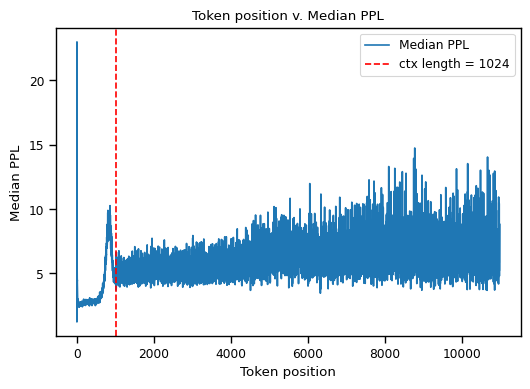

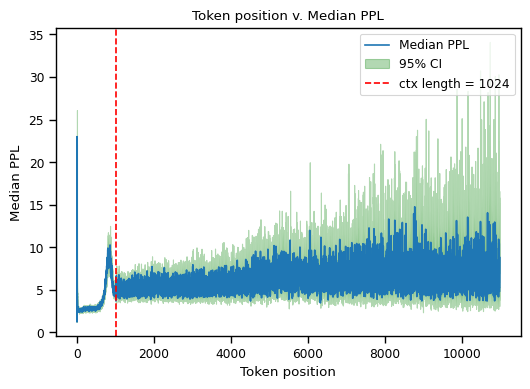

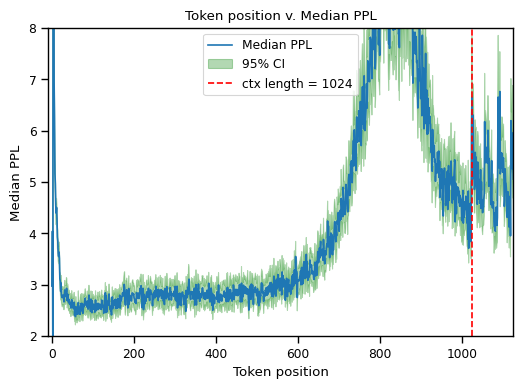

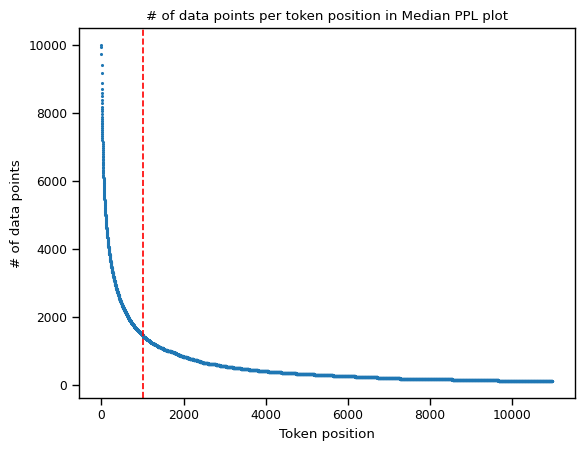

In [144]:
# Calculate median ppl per token position
df_pos_to_ppl = calculate_ppl_per_token_pos(df)

# Plot (without CI)
plot_token_idx_v_ppl(df_pos_to_ppl, ctx_length=1024, is_show_ci=False, is_zoom_to_ctx=False)

if is_plot_ci:
    # Plot (with CI)
    plot_token_idx_v_ppl(df_pos_to_ppl, ctx_length=1024, is_show_ci=True, is_zoom_to_ctx=False)
    # Plot (with CI) zoomed into ctx length
    plot_token_idx_v_ppl(df_pos_to_ppl, ctx_length=1024, is_show_ci=True, is_zoom_to_ctx=True)

# Print count of measurements per token position
plt.scatter(df_token_position_counts[df_token_position_counts['token_idx'].isin(keep_token_idxs)]['token_idx'], 
         df_token_position_counts[df_token_position_counts['token_idx'].isin(keep_token_idxs)]['count'],
         s=2)
plt.xlabel('Token position')
plt.axvline(x=1024, color='red', linestyle='--', label='ctx length = 1024')
plt.ylabel('# of data points')
plt.title('# of data points per token position in Median PPL plot')
plt.show()

Note: There's some unfortunate PPL cyclicality due to the stride length being 32

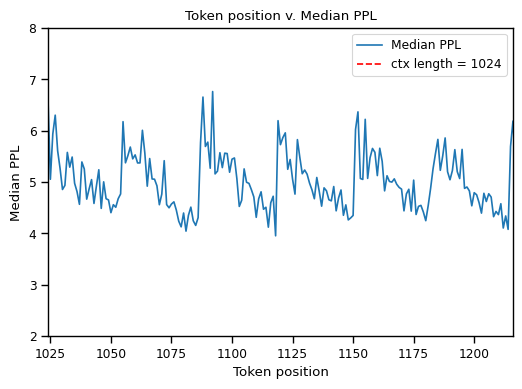

In [47]:
# Plot artifact of stride length = 32
plt.figure(figsize=(6, 4))
plt.plot(df_pos_to_ppl['token_idx'], df_pos_to_ppl['median'], label='Median PPL')
plt.xlabel('Token position')
plt.ylabel('Median PPL')
plt.title('Token position v. Median PPL')
plt.axvline(x=1024, color='red', linestyle='--', label='ctx length = 1024')
plt.xlim(1024, 1024 + 32 * 6)
plt.ylim(2, 8)
plt.legend()
plt.show()

## What's going on at that peak?

What are the tokens causing the weird peak `token_idx` 850?

**Hypos:**
* It could just be that the absolute positional embeddings between 850-1000 are undertrained in the model
    * To test this, see if peak is observed with diff ctxt length gpt base models
* It could be that most patient timelines end at that token position? [FALSE]
    * To test this, plot the dist. of lengths of patient timelines in val split
* It could be a few tokens?
    * To test this, come up with a list of highest mean/median ppl scoring tokens

### Hypo: Caused by patient timeline lengths in Val dataset truncating around `token_idx`

Verdict: False

Idea: If most val patient timelines end around `token_idx` 850, so we're catching the "final days" of lots of patients here (which are harder to predict)

==== Percentiles ====
    percentile       ppl
0            0     2.000
1           10   215.100
2           20   432.200
3           30   665.300
4           40   940.400
5           50  1267.000
6           60  1789.600
7           70  2417.700
8           80  3635.000
9           90  6554.800
10          95 10546.800
11          99 27898.590
12         100 76673.000


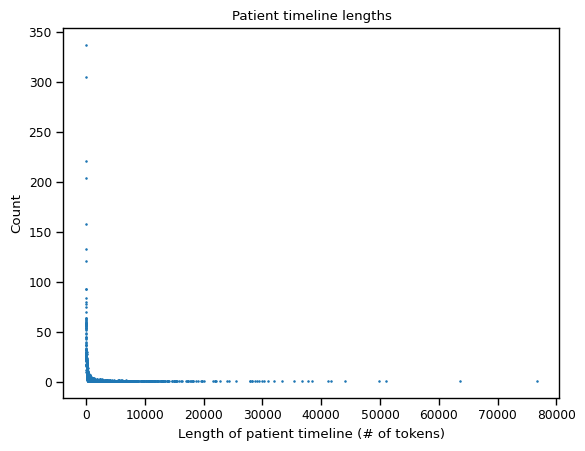

In [40]:
df_n_tokens_counts = df.groupby('pid').agg({ 'n_tokens': 'first' }).reset_index()['n_tokens'].value_counts().reset_index()
print_percentiles(df_n_tokens_counts['n_tokens'])
plt.scatter(df_n_tokens_counts['n_tokens'], df_n_tokens_counts['count'], s=2)
plt.xlabel('Length of patient timeline (# of tokens)')
plt.ylabel('Count')
plt.title('Patient timeline lengths')
plt.show()

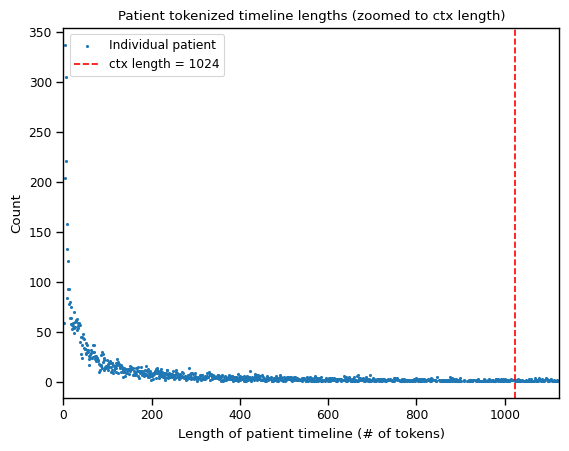

In [52]:
# Zoom in on 0 - ctx length
plt.scatter(df_n_tokens_counts['n_tokens'], df_n_tokens_counts['count'], s=2, label='Individual patient')
plt.axvline(x=1024-1, color='red', linestyle='--', label='ctx length = 1024')
plt.xlabel('Length of patient timeline (# of tokens)')
plt.ylabel('Count')
plt.xlim(0, 1024 + 100)
plt.legend()
plt.title('Patient tokenized timeline lengths (zoomed to ctx length)')
plt.show()

### Hypo: Caused by patient timeline lengths in Train dataset truncating around `token_idx`

Verdict: TBD

Idea: If most training examples are truncated early, then certain positional embeddings will be undertrained

Experiment: Loop through FEMRDataset Dataloader for diff context length values, and plot distribution of lengths of sampled examples

In [107]:
TODO

NameError: name 'TODO' is not defined

### Hypo: Caused by those `token_idx` just being more random

Verdict: Yes, the tokens appear to be more "random" as you get deeper into a patient timeline, per both the **diversity of tokens** and **entropy of tokens** measurements below.

Idea: For some reason, the positions around `token_idx` are literally just weirder tokens. Let's try to measure this without relying on PPL. 

A couple ways:
1. Diversity of tokens: Count % of tokens that appear at each token position which are unique in val dataset
2. Entropy of tokens: Calculate mean/median entropy (according to CLMBR tokenizer) of tokens that appear at each token position in val dataset

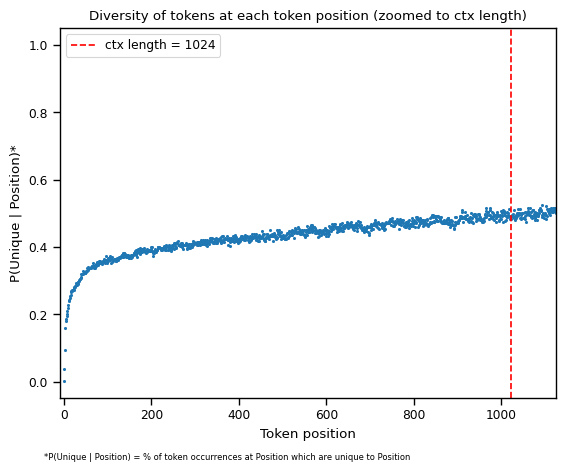

In [94]:
# Diversity of Tokens
#   Count which % of tokens that appear at each token position are unique to that position
df_pos_unique_tokens_pcts = df.groupby('token_idx').agg({ 'label': lambda x: x.nunique() / x.count() }).reset_index().rename(columns={ 'label': 'count' })
plt.scatter(df_pos_unique_tokens_pcts['token_idx'], df_pos_unique_tokens_pcts['count'], s=2)
plt.xlabel('Token position')
plt.ylabel('P(Unique | Position)*')
plt.title('Diversity of tokens at each token position (zoomed to ctx length)')
plt.axvline(x=1024-1, color='red', linestyle='--', label='ctx length = 1024')
plt.legend()
plt.xlim(-10, 1024 + 100)
plt.figtext(0.1, -0.02, "*P(Unique | Position) = % of token occurrences at Position which are unique to Position", ha="left", fontsize=6)
plt.show()

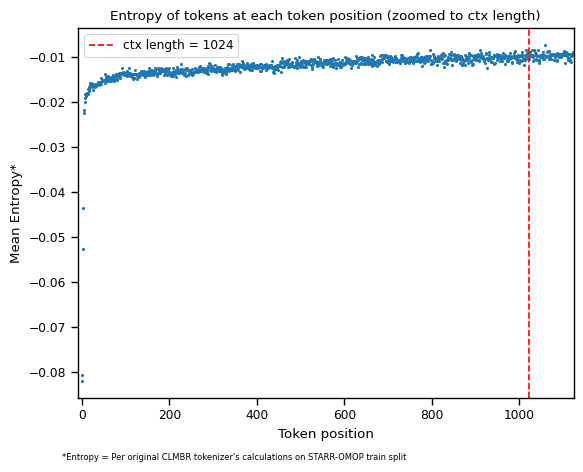

In [93]:
# Entropy of Tokens
#   Calculate mean/median entropy (according to CLMBR tokenizer) of tokens that appear at each token position
# Load CLMBR tokenizer
clmbr_vocab: List[Dict] = json.load(open('/share/pi/nigam/mwornow/hf_ehr/cache/tokenizers/clmbr_v8/clmbr_v8_original_dictionary.json', 'r'))['regular']
label_2_entropy: Dict[int, float] = { idx + N_SPECIAL_TOKENS: token['weight'] for idx, token in enumerate(clmbr_vocab) }
# Calculate entropy of each token
df['entropy'] = df['label'].map(label_2_entropy)
# Calculate mean/median entropy of tokens at each token position
df_pos_entropy = df.groupby('token_idx').agg({ 'entropy': 'mean', }).reset_index()

# Plot
xlim_start, xlim_end = 0, 1024 + 100
plt.scatter(df_pos_entropy.iloc[xlim_start:xlim_end]['token_idx'], df_pos_entropy.iloc[xlim_start:xlim_end]['entropy'], s=2)
plt.xlabel('Token position')
plt.ylabel('Mean Entropy*')
plt.title('Entropy of tokens at each token position (zoomed to ctx length)')
plt.axvline(x=1024-1, color='red', linestyle='--', label='ctx length = 1024')
plt.legend()
plt.xlim(xlim_start - 10, xlim_end)
plt.figtext(0.1, -0.02, "*Entropy = Per original CLMBR tokenizer's calculations on STARR-OMOP train split", ha="left", fontsize=6)
plt.show()

### Hypo: Caused by ctx length of 1024

Verdict: TBD

Idea: This is an artifact of using a ctx length of 1024, so test `gpt-base-512`, `2048`, `4096`

### Hypo: Caused by gpt-base model

Verdict: TBD

Idea: This is an artifact of `gpt-base`, so test `mamba-tiny-1024` and `hyena-medium-1024` as well

# What are the most surprising tokens?


**Experiment:**
* Run `gpt-base-1024--clmbr` on validation patients, and measure ppl associated with each token.
* 

# How does ctxt length affect PPL?

Run these commands to generate the results used in this section:

```bash
# PPL across ctx lengths
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-2048--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-4096--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-512--clmbr --stride 32 --n_patients 10000
```

**Experiment:**
* Run `gpt-base-k--clmbr` models on the same set of validation patients, with $k \in \{512, 1k, 2k, 4k\}$. Measure the overall ppl for each model.

In [96]:
df_ctxs = {}
for k in [ 512, 1024, 2048, 4096 ]:
    path_to_base_results: str = f'/share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-{k}--clmbr/ppl/val/'
    path_to_10k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=10000-is_config=False')
    file_name = [ x for x in os.listdir(path_to_10k) if x.endswith('.parquet') ][0]
    df_ctxs[k] = pd.read_parquet(os.path.join(path_to_10k, file_name))
    print(f"Loaded {k} with shape={df_ctxs[k].shape}")

Loaded 512 with shape=(6380620, 14)
Loaded 1024 with shape=(7407861, 14)
Loaded 2048 with shape=(6400057, 14)
Loaded 4096 with shape=(6406221, 14)


In [101]:
for k in [ 512, 1024, 2048, 4096 ]:
    print(f">>>>>>>> Ctxt = {k} <<<<<<<<")
    print_percentiles(df_ctxs[k]['label_ppl'])

>>>>>>>> Ctxt = 512 <<<<<<<<


==== Percentiles ====
    percentile          value
0            0          1.000
1           10          1.187
2           20          1.918
3           30          3.141
4           40          5.090
5           50          8.308
6           60         14.798
7           70         30.998
8           80         87.384
9           90        472.712
10          95       2135.756
11          99      37165.962
12         100 3843182847.201
>>>>>>>> Ctxt = 1024 <<<<<<<<
==== Percentiles ====
    percentile           value
0            0           1.000
1           10           1.058
2           20           1.384
3           30           2.037
4           40           3.102
5           50           4.760
6           60           7.510
7           70          13.610
8           80          33.210
9           90         164.178
10          95         765.303
11          99       16672.829
12         100 21648180707.099
>>>>>>>> Ctxt = 2048 <<<<<<<<
==== Percentiles ====
    percentile      

In [103]:
# Calculate median PPL per token position
df_ctxs__pos_to_ppl = {}
for k in [ 512, 1024, 2048, 4096 ]:
    df_ctxs__pos_to_ppl[k] = calculate_ppl_per_token_pos(df_ctxs[k])
    df_ctxs__pos_to_ppl[k]['ema_median'] = df_ctxs__pos_to_ppl[k]['median'].ewm(span=20, adjust=False).mean()

Keeping 9919 token positions (i.e. all token positions with >= 100 data points)


Processing token positions:   0%|          | 24/9919 [00:00<01:27, 113.61it/s]

Processing token positions: 100%|██████████| 9919/9919 [01:06<00:00, 148.29it/s]


Keeping 10975 token positions (i.e. all token positions with >= 100 data points)


Processing token positions: 100%|██████████| 10975/10975 [01:30<00:00, 120.63it/s]


Keeping 9919 token positions (i.e. all token positions with >= 100 data points)


Processing token positions: 100%|██████████| 9919/9919 [01:07<00:00, 146.10it/s]


Keeping 9919 token positions (i.e. all token positions with >= 100 data points)


Processing token positions: 100%|██████████| 9919/9919 [01:07<00:00, 147.84it/s]


>>>>>>>> Ctxt = 512 <<<<<<<<


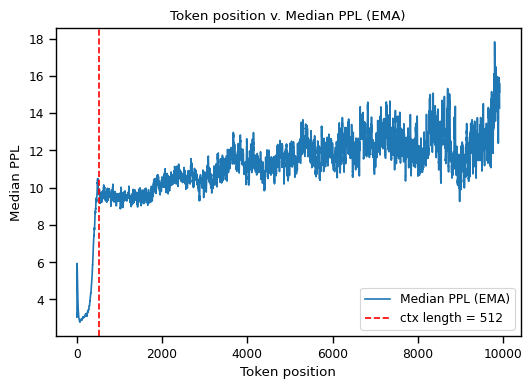

>>>>>>>> Ctxt = 1024 <<<<<<<<


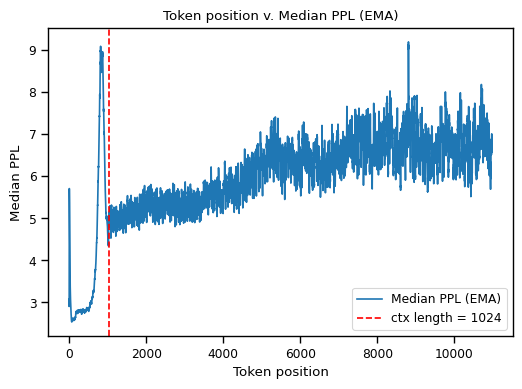

>>>>>>>> Ctxt = 2048 <<<<<<<<


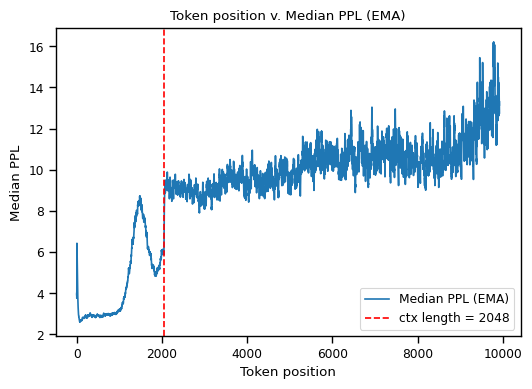

>>>>>>>> Ctxt = 4096 <<<<<<<<


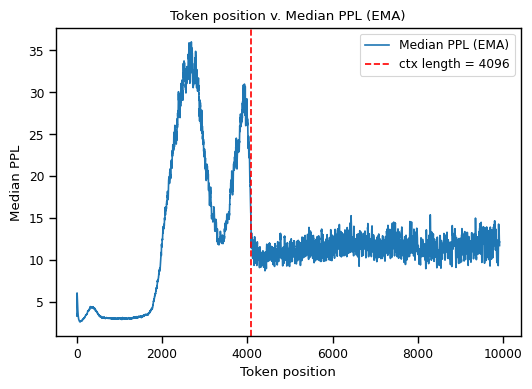

In [148]:
# Plot median PPL per token position for each ctx length
for k in [ 512, 1024, 2048, 4096 ]:
    print(f">>>>>>>> Ctxt = {k} <<<<<<<<")
    plot_token_idx_v_ppl(df_ctxs__pos_to_ppl[k], ctx_length=k, is_use_ema=True, is_show_ci=False, is_zoom_to_ctx=False)

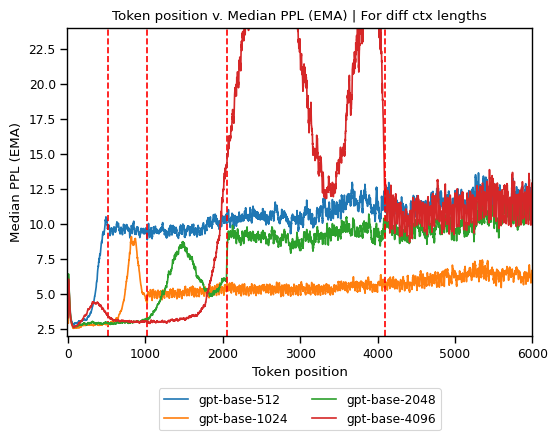

In [150]:
# Show all on same plot
plt.figure(figsize=(6, 4))
for k in [ 512, 1024, 2048, 4096 ]:
    plt.plot(df_ctxs__pos_to_ppl[k]['token_idx'], df_ctxs__pos_to_ppl[k]['ema_median'], label=f'gpt-base-{k}')
    plt.axvline(x=k, color='red', linestyle='--')
plt.xlabel('Token position')
plt.ylabel('Median PPL (EMA)')
plt.title('Token position v. Median PPL (EMA) | For diff ctx lengths')
plt.xlim(-10, 6000)
plt.ylim(2, 24)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()

In [132]:
# Plot PPL for first k tokens across diff models
token_span_start, token_span_end = 0, 4096
df_r = []
valid_pids = df_ctxs[512]['pid'].value_counts()[df_ctxs[512]['pid'].value_counts() >= token_span_end].index # only keep pids that have at least `token_span_end` tokens
for k in [ 512, 1024, 2048, 4096 ]:
    df_ = df_ctxs[k]
    # Filter to valid pids
    df_ = df_[df_['pid'].isin(valid_pids)]
    assert df_['pid'].nunique() == len(valid_pids), f"Not all pids were found for k={k}"
    # Calculate PPL for first k tokens
    ppl = np.exp(-df_[(token_span_start <= df_['token_idx']) & (df_['token_idx'] <= token_span_end)]['label_log_prob'].mean())
    df_r.append({
        'ctx_length': k,
        'ppl': ppl
    })
df_r = pd.DataFrame(df_r)
df_r

AssertionError: Not all pids were found for k=1024

# How does model architecture affect PPL?

Run these commands to generate the results used in this section:

```bash
# PPL across ctx lengths
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/mamba-tiny-1024--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/mamba-tiny-4096--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/mamba-tiny-16384--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/hyena-medium-1024--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/hyena-medium-4096--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/hyena-medium-16384--clmbr --stride 32 --n_patients 10000
```

**Experiment:**
* Run `m-k--clmbr` on the same set of validation patients, with $m \in \{ \text{gpt}, \text{hyena}, \text{mamba} \}$ and $k \in \{1k, 4k, 16k\}$. Measure the overall ppl for each model.

In [152]:
# Load data for all models/ctx lengths
df_models = {} # [key] = (model, ctx_length), [value] = df
for m in [ 'gpt-base', 'mamba-tiny', 'hyena-medium' ]:
    for k in [ 1024, 4096, 16384,]:
        path_to_base_results: str = f'/share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/{m}-{k}--clmbr/ppl/val/'
        path_to_10k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=10000-is_config=False')
        if not os.path.exists(path_to_10k):
            continue
        file_name = [ x for x in os.listdir(path_to_10k) if x.endswith('.parquet') ][0]
        df_models[(m,k)] = pd.read_parquet(os.path.join(path_to_10k, file_name))
        print(f"Loaded {m}-{k} with shape={df_models[(m,k)].shape}")

Loaded gpt-base-1024 with shape=(7407861, 14)
Loaded gpt-base-4096 with shape=(6406221, 14)
Loaded mamba-tiny-1024 with shape=(6392122, 14)
Loaded mamba-tiny-4096 with shape=(6406221, 14)
Loaded mamba-tiny-16384 with shape=(6411071, 14)
Loaded hyena-medium-1024 with shape=(6392122, 14)
Loaded hyena-medium-4096 with shape=(6406221, 14)
Loaded hyena-medium-16384 with shape=(6411071, 14)


In [173]:
# Calculate median PPL per token position
df_models__pos_to_ppl = {}
for key in df_models.keys():
    df_models__pos_to_ppl[key] = calculate_ppl_per_token_pos(df_models[key])

Keeping 21887 token positions (i.e. all token positions with >= 30 data points)


Processing token positions:   0%|          | 0/21887 [00:00<?, ?it/s]

Processing token positions: 100%|██████████| 21887/21887 [02:51<00:00, 127.79it/s]


Keeping 20383 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 20383/20383 [02:17<00:00, 147.97it/s]


Keeping 20383 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 20383/20383 [02:15<00:00, 150.85it/s]


Keeping 20383 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 20383/20383 [02:16<00:00, 149.74it/s]


Keeping 20383 token positions (i.e. all token positions with >= 30 data points)


Processing token positions:  12%|█▏        | 2475/20383 [00:17<02:01, 146.87it/s]

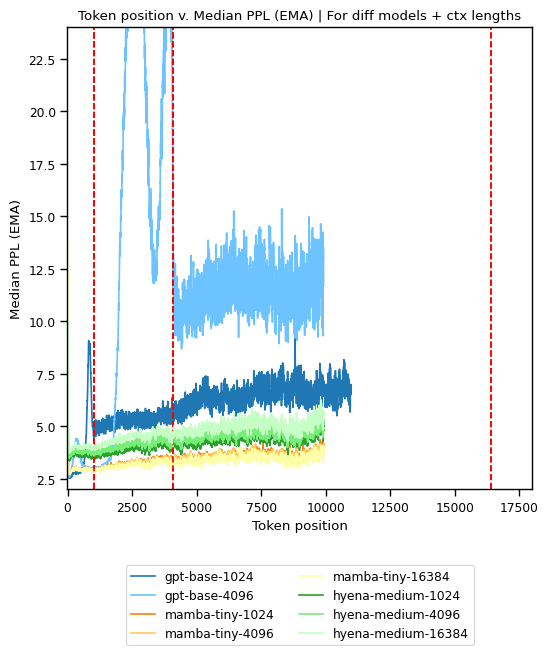

In [169]:
# Show all on same plot
color_map = plt.get_cmap('tab10')  # You can use other colormaps too
model_2_color = {
    'gpt-base': color_map(0),
    'mamba-tiny': color_map(1),
    'hyena-medium': color_map(2)
}

plt.figure(figsize=(6, 6))
for m_idx, m in enumerate([ 'gpt-base', 'mamba-tiny', 'hyena-medium' ]):
    for k_idx, k in enumerate([ 1024, 4096, 16384,]):
        if (m,k) not in df_models__pos_to_ppl: continue
        color = [min(c + 0.3 * k_idx, 1) for c in model_2_color[m][:3]] + [1.0]
        plt.plot(df_models__pos_to_ppl[(m,k)]['token_idx'], df_models__pos_to_ppl[(m,k)]['ema_median'], label=f'{m}-{k}', color=color)
        plt.axvline(x=k, color='red', linestyle='--')
plt.xlabel('Token position')
plt.ylabel('Median PPL (EMA)')
plt.title('Token position v. Median PPL (EMA) | For diff models + ctx lengths')
plt.xlim(-10, 18000)
plt.ylim(2, 24)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()

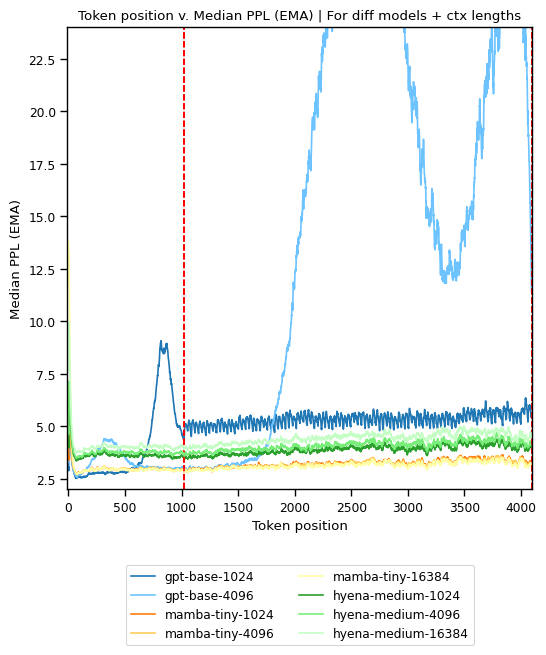

In [168]:
# Zoom in
plt.figure(figsize=(6, 6))
for m_idx, m in enumerate([ 'gpt-base', 'mamba-tiny', 'hyena-medium' ]):
    for k_idx, k in enumerate([ 1024, 4096, 16384,]):
        if (m,k) not in df_models__pos_to_ppl: continue
        color = [min(c + 0.3 * k_idx, 1) for c in model_2_color[m][:3]] + [1.0]
        plt.plot(df_models__pos_to_ppl[(m,k)]['token_idx'], df_models__pos_to_ppl[(m,k)]['ema_median'], label=f'{m}-{k}', color=color)
        plt.axvline(x=k, color='red', linestyle='--')
plt.xlabel('Token position')
plt.ylabel('Median PPL (EMA)')
plt.title('Token position v. Median PPL (EMA) | For diff models + ctx lengths')
plt.xlim(-10, 4100)
plt.ylim(2, 24)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()

# How does vocab size affect the presence of outliers?

Run these commands to generate the results used in this section:

```bash
[TODO]
# PPL across vocab sizes
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr_16k --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr_64k --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr_96k --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr_118k --stride 32 --n_patients 10000
```

Does decreasing the vocab size reduce the frequency of high token-level-ppl predictions?

**Experiment:**
* Run `gpt-base-1024--clmbr_k` on the same set of validation patients, with $k \in \{16k, 40k, 96k, 118k\}$.
* Measure frequency of outliers in terms of token-level-ppl

# 